# Описание анализа

В последние десятилетия случаи применения силы со стороны полиции, особенно с летальным исходом, привлекли значительное внимание общества. Одним из наиболее известных инцидентов стало убийство Джорджа Флойда в 2020 году, что вызвало массовые протесты и дискуссии о полицейском насилии и предвзятости (BBC News, 2020).

Цель анализа — исследовать факторы, связанные с подобными инцидентами, чтобы понять, какие условия способствуют возникновению таких ситуаций. Исследование основано на данных о случаях применения силы, включая демографические и географические аспекты (The Washington Post, 2021).

Источники:
1. Данные о применении силы полицией в США. Ссылка: https://fondfbr.ru/stati/police-violence-us-data-analysis/?utm_source=chatgpt.com

2. Убийство Джорджа Флойда: Подробное описание инцидента и его последствий можно найти в статье на Википедии. Ссылка: https://ru.wikipedia.org/wiki/Убийство_Джорджа_Флойда?utm_source=chatgpt.com

## 1. Знакомство с данными

### Источник данных:
[Данные](https://www.kaggle.com/datasets/kwullum/fatal-police-shootings-in-the-us/data) взяты с Kaggle и содержат информацию о случаях убийства полицейских в США. В таблице представлены сведения о жертве, обстоятельствах происшествия и других факторах.

### Цель анализа:
Определить основные факторы, влияющие на вероятность убийства полицейского. Анализ поможет выявить закономерности, которые могут способствовать повышению безопасности сотрудников правоохранительных органов.

### Описание столбцов:

- `id` - Уникальный идентификатор записи, числовой (int).

- `Name` - Имя убитого офицера, строковой (object).

- `Age` - Возраст офицера на момент смерти, числовой (int).

- `Gender` - Пол офицера (Male, Female), категориальный (object).

- `Race` - Расовая принадлежность офицера, категориальный (object).

- `Department` - Название полицейского департамента, в котором служил офицер, строковой (object).

- `State` - Штат, в котором произошло убийство, строковой (object).

- `Cause of Death` - Причина смерти (например, огнестрельное ранение, ножевое ранение), строковой (object).

- `Weapon Used` - Оружие, использованное при убийстве, строковой (object).

- `Incident Date` - Дата происшествия, формат даты (datetime).

- `Suspect Age` - Возраст подозреваемого, числовой (int).

- `Suspect Gender` - Пол подозреваемого (Male, Female), категориальный (object).

- `Suspect Race` - Расовая принадлежность подозреваемого, категориальный (object).

- `Criminal Record` - Наличие судимостей у подозреваемого (Yes, No), категориальный (object).

- `Charges` - Предъявленные обвинения, строковой (object).

- `Convicted` - Был ли подозреваемый осужден (Yes, No), категориальный (object).

### Подход к загрузке данных 

Так как у нас было несколько таблиц, я сначала скорректировал их названия: привел к нижнему регистру и заменил пробелы на подчеркивания для единообразия. Затем все таблицы были загружены в DuckDB.  

Я предпочел работать с данными в формате DataFrame: загружать их из базы, затем при необходимости очищать выбросы и рассчитывать ключевые метрики. Такой подход позволяет гибко анализировать данные и не потерять ни одной части данных, использовать для анализа только необходимую часть.

Подход сделано на python файле на этой папке (ddl.py)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import duckdb
import plotly.express as px
import os

### Функция для вывода базовых информации

In [2]:
def get_basic_info(df: pd.DataFrame, name: str):
    """
    Выводит базовую информацию о DataFrame.

    :param df: pandas DataFrame
    :param name: название DataFrame
    """
    print("Первый 5 строк:")
    print(df.head())
    print(f"📌 Информация о {name}")
    print(f"Форма: {df.shape}")  # (количество строк, количество столбцов)
    print("\nПропущенные значения:")
    print(df.isnull().sum())  # Количество пропусков по столбцам
    print("\nОсновная статистика:")
    print(df.describe())  # Базовая статистика (среднее, медиана, квантили)

### Функция для обработка данных

In [3]:
def preprocess_and_clean(df: pd.DataFrame):
    """
    Полная предобработка данных:
    - Удаляет дубликаты
    - Удаляет строки с пропусками
    - Приводит числовые столбцы к float
    - Удаляет выбросы методом IQR
    
    :param df: pandas DataFrame
    :return: Очищенный DataFrame
    """
    initial_shape = df.shape
    df = df.drop_duplicates()
    print(f"✅ Удалены дубликаты. Было {initial_shape[0]}, стало {df.shape[0]} строк.")

    initial_shape = df.shape
    df = df.dropna()
    print(f"🧹 Удалены строки с пропусками. Было {initial_shape[0]}, стало {df.shape[0]} строк.")

    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = df[col].astype(float)
        print(f"🔢 Столбец '{col}' приведен к float.")

        # Удаление выбросов
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        initial_shape = df.shape
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        print(f"📉 Выбросы в '{col}' удалены. Было {initial_shape[0]}, стало {df.shape[0]} строк.")

    print("🎯 Предобработка завершена!")
    return df

### Функция анализируемы данные до и после очистки.

In [4]:
def analyze_data_cleaning(df: pd.DataFrame, name: str):
    """
    Анализ процесса очистки данных:
    - Подсчет удаленных строк
    - Вычисление процента потерь
    - Визуализация результата
    - Сравнение количества строк до и после очистки

    :param df: pandas DataFrame
    :param name: название набора данных
    :return: None
    """
    initial_row_count = df.shape[0]
    
    # Преобразуем данные, заменяя ошибки на NaN и удаляем строки с NaN
    df_cleaned = df.apply(pd.to_numeric, errors='coerce').dropna()
    final_row_count = df_cleaned.shape[0]
    
    # Подсчитываем удаленные строки
    removed_rows = initial_row_count - final_row_count
    removed_percentage = (removed_rows / initial_row_count) * 100

    print(f"📊 Анализ очистки для {name}")
    print(f"Изначальное количество строк: {initial_row_count}")
    print(f"Количество строк после очистки: {final_row_count}")
    print(f"Удалено строк: {removed_rows} ({removed_percentage:.2f}%)")

    # Визуализация результата
    plt.figure(figsize=(6, 4))
    plt.bar(['Удалено', 'Осталось'], [removed_rows, final_row_count], color=['red', 'green'])
    plt.ylabel('Количество строк')
    plt.title(f'Удаление строк в процессе очистки ({name})')
    plt.show()

    return None

 ### Обоснование удаления выбросов
1. Доход домохозяйств (MedianHouseholdIncome2015) – слишком низкий или высокий доход может быть ошибкой в данных или аномальной ситуацией.

2. Уровень бедности (PercentagePeopleBelowPovertyLevel) – значения выше 100% невозможны, а аномально низкие могут быть ошибочными.

3. Образование (PercentOver25CompletedHighSchool) – нормальный диапазон 0-100%, выбросы могут быть связаны с неверными записями.

4. Данные о смертях от полиции (PoliceKillingsUS) – аномальные всплески могут быть вызваны ошибками в данных или разовыми событиями.
    
5. Расовый состав городов (ShareRaceByCity) – проценты должны суммироваться до 100%, если больше – ошибка.

### Метрики
1.	Корреляция между числовыми переменными (например, через df.corr()). Визуализируем тепловой картой.

2.	Распределение числовых данных (гистограмма или boxplot). Позволяет увидеть нормальность распределения и выбросы.

3.	Меры центральной тенденции (среднее, медиана, мода). Можно сделать bar chart.

4.	Размах и дисперсия (разница между мин/макс и стандартное отклонение). Хорошо смотрится на boxplot.

5.	Распределение категориальных данных (bar chart с частотами категорий).

6.	Временные ряды (если в данных есть даты, то тренд over time). Строим линейный график.

7.	Сравнение уровня дохода и образования по разным долям рас (кластеризация/сегментация по race-share)


### 1. Корреляция между числовыми переменными (например, через df.corr()). Визуализируем тепловой картой.

##### Описание:
* Анализ корреляции позволяет определить силу и направление связи между двумя числовыми признаками. Например, насколько сильно уровень бедности связан с доходом.

* Зачем это нужно:
Позволяет найти потенциальные зависимости и взаимосвязи, которые могут повлиять на дальнейший анализ или принятие решений.

* Визуализация:
Тепловая карта (heatmap) на основе df.corr().

In [5]:
# Подключаемся к db
db_path = "final_project.duckdb"
conn = duckdb.connect(db_path)

In [6]:
print(conn.execute("SHOW TABLES").fetchdf())

                                name
0          MedianHouseholdIncome2015
1   PercentOver25CompletedHighSchool
2  PercentagePeopleBelowPovertyLevel
3                   PoliceKillingsUS
4                    ShareRaceByCity
5             city_demographics_view
6         city_education_police_view


In [7]:
# SQL-запрос на создание новой VIEW
query = """
DROP VIEW IF EXISTS city_demographics_view;

CREATE VIEW city_demographics_view AS
SELECT
    CASE 
        WHEN a.poverty_rate ~ '^[0-9.]+$' THEN CAST(a.poverty_rate AS DOUBLE)
        ELSE NULL
    END AS poverty_rate,

    CASE 
        WHEN b.median_income ~ '^[0-9]+$' THEN CAST(b.median_income AS INTEGER)
        ELSE NULL
    END AS median_income,

    CASE 
        WHEN c.percent_completed_hs ~ '^[0-9.]+$' THEN CAST(c.percent_completed_hs AS DOUBLE)
        ELSE NULL
    END AS percent_completed_hs,

    CASE 
        WHEN d.share_white ~ '^[0-9.]+$' THEN CAST(d.share_white AS DOUBLE)
        ELSE NULL
    END AS share_white,

    CASE 
        WHEN d.share_black ~ '^[0-9.]+$' THEN CAST(d.share_black AS DOUBLE)
        ELSE NULL
    END AS share_black,

    CASE 
        WHEN d.share_hispanic ~ '^[0-9.]+$' THEN CAST(d.share_hispanic AS DOUBLE)
        ELSE NULL
    END AS share_hispanic,

    CASE 
        WHEN d.share_asian ~ '^[0-9.]+$' THEN CAST(d.share_asian AS DOUBLE)
        ELSE NULL
    END AS share_asian

FROM
    MedianHouseholdIncome2015 a
JOIN
    PercentagePeopleBelowPovertyLevel b 
    ON a.city = b.city AND a.geographic_area = b.geographic_area
JOIN
    ShareRaceByCity c 
    ON a.city = c.city AND a.geographic_area = c.geographic_area
JOIN
    PoliceKillingsUS d 
    ON a.city = d.city AND a.geographic_area = d.geographic_area;
"""

# Выполнение запроса
conn.execute(query)

print("✅ Вьюшка city_education_police_view успешно создана.")

✅ Вьюшка city_education_police_view успешно создана.


In [8]:
# SQL запрос для объединения таблиц и получения нужных данных
query = """
SELECT * FROM city_demographics_view;
"""

# Получаем данные
df_correlation = conn.execute(query).fetchdf()

# Преобразуем столбцы в float, заменяя значения, которые не могут быть преобразованы
columns_to_convert = ['poverty_rate', 'median_income', 'percent_completed_hs', 'share_asian', 'share_white', 'share_black', 'share_hispanic']

#### Принимаем наше вышесозданные функции на наш df

In [9]:
get_basic_info(df_correlation, "Correlation Data")

Первый 5 строк:
   poverty_rate  median_income  percent_completed_hs  share_white  \
0          78.8          11207                  21.2         67.2   
1          29.1          25615                  69.1         54.4   
2          25.5          42575                  78.9         52.3   
3          30.7          37083                  81.4         99.1   
4          42.0          21667                  68.6         13.2   

   share_black  share_hispanic  share_asian  
0         30.2             1.6          0.0  
1         41.4             3.1          1.0  
2         44.9             2.3          0.3  
3          0.1             0.4          0.1  
4         86.5             0.3          0.0  
📌 Информация о Correlation Data
Форма: (29115, 7)

Пропущенные значения:
poverty_rate             195
median_income           1905
percent_completed_hs     191
share_white               19
share_black               19
share_hispanic            19
share_asian               19
dtype: int64

Осн

In [10]:
preprocess_and_clean(df_correlation)

✅ Удалены дубликаты. Было 29115, стало 28937 строк.
🧹 Удалены строки с пропусками. Было 28937, стало 27208 строк.
🔢 Столбец 'poverty_rate' приведен к float.
📉 Выбросы в 'poverty_rate' удалены. Было 27208, стало 26489 строк.
🔢 Столбец 'percent_completed_hs' приведен к float.
📉 Выбросы в 'percent_completed_hs' удалены. Было 26489, стало 25629 строк.
🔢 Столбец 'share_white' приведен к float.
📉 Выбросы в 'share_white' удалены. Было 25629, стало 23336 строк.
🔢 Столбец 'share_black' приведен к float.
📉 Выбросы в 'share_black' удалены. Было 23336, стало 19920 строк.
🔢 Столбец 'share_hispanic' приведен к float.
📉 Выбросы в 'share_hispanic' удалены. Было 19920, стало 17632 строк.
🔢 Столбец 'share_asian' приведен к float.
📉 Выбросы в 'share_asian' удалены. Было 17632, стало 15998 строк.
🎯 Предобработка завершена!


,poverty_rate,median_income,percent_completed_hs,share_white,share_black,share_hispanic,share_asian
3,30.7,37083,81.4,99.1,0.1,0.4,0.1
11,27.5,27566,66.9,95.8,1.7,1.1,0.2
13,13.8,34792,85.7,97.9,0.0,0.7,0.0
15,16.7,40292,87.6,96.6,0.1,1.7,0.7
16,19.1,35670,77.7,94.3,1.9,1.3,0.9
...,...,...,...,...,...,...,...
29102,3.3,101667,93.1,97.1,0.0,1.9,0.1
29107,12.0,34984,92.7,95.1,0.1,7.4,0.7
29109,2.9,94792,100.0,97.5,0.2,1.8,0.8
29112,5.9,77114,89.2,94.5,0.1,6.2,0.2


In [11]:
# Сначала преобразуем указанные колонки в числа с очисткой
columns_to_convert = ['poverty_rate', 'median_income', 'percent_completed_hs', 'share_white', 'share_black', 'share_asian', 'share_hispanic']

for col in columns_to_convert:
    df_correlation[col] = df_correlation[col].astype(str).str.strip()
    df_correlation[col] = pd.to_numeric(df_correlation[col], errors='coerce')

# Оставляем только числовые колонки для корреляции
df_numeric = df_correlation[columns_to_convert]

### Обработка данных и решение ошибки при расчете корреляции

В процессе анализа данных была обнаружена ошибка при попытке рассчитать корреляцию между числовыми переменными. Ошибка возникала из-за того, что в некоторых столбцах присутствовали значения, которые невозможно было преобразовать в числовой тип (например, символы `'-'`).

Для решения этой проблемы был применен следующий подход:
1. **Преобразование данных**: Для каждого числового столбца, содержащего такие значения, был применен метод `pd.to_numeric()`, который преобразует строки в числа. Все значения, которые не могли быть преобразованы (например, символы `'-'`), заменялись на `NaN` с помощью параметра `errors='coerce'`.
2. **Расчет корреляции**: После обработки данных, все числовые столбцы стали совместимыми с методом `.corr()`, который теперь смог корректно рассчитать матрицу корреляции между переменными.
3. **Визуализация**: Результаты корреляции были визуализированы с помощью тепловой карты (heatmap) для наглядности.

Этот процесс позволил эффективно устранить ошибку и получить точные данные для дальнейшего анализа.

In [12]:
# Рассчитываем корреляцию между числовыми переменными
correlation_matrix = df_correlation.corr()

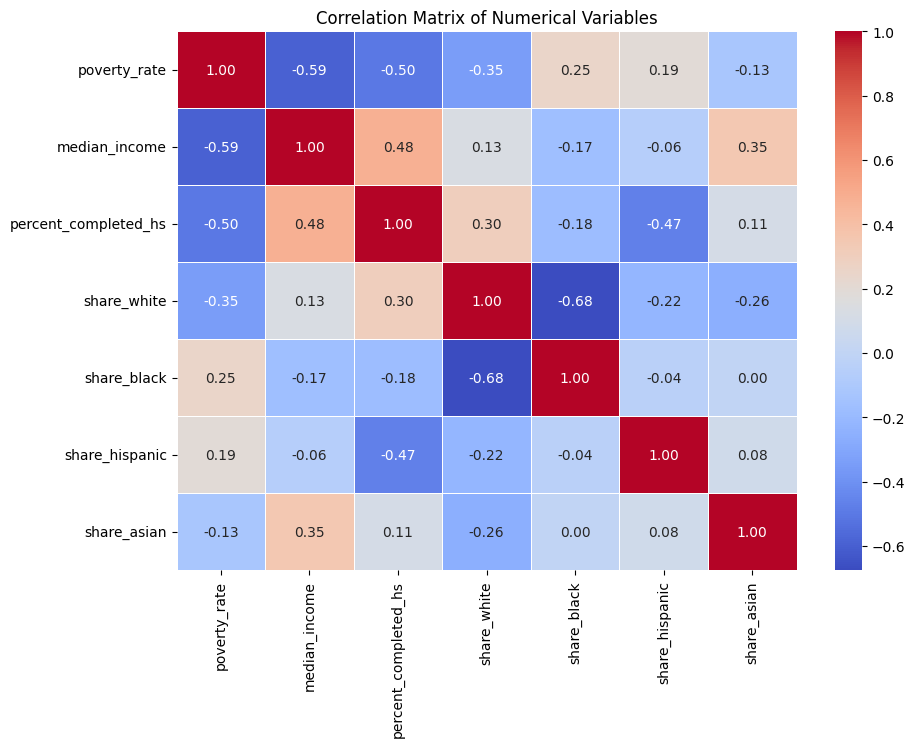

In [13]:
# Визуализируем тепловую карту
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

#### Сравнить с первоначальное данные

📊 Анализ очистки для Correlation Data
Изначальное количество строк: 29115
Количество строк после очистки: 27210
Удалено строк: 1905 (6.54%)


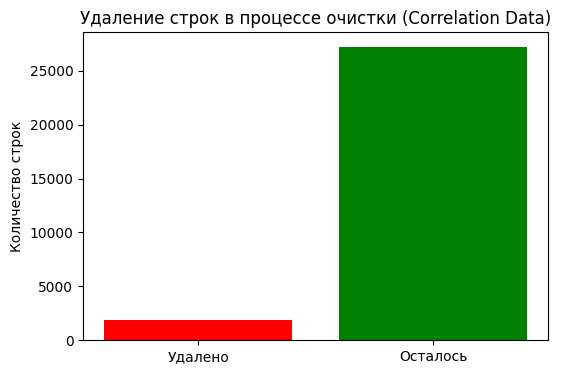

In [14]:
analyze_data_cleaning(df_correlation, "Correlation Data")

### 2. Распределение числовых данных (гистограмма boxplot). Позволяет увидеть нормальность распределения и выбросы.

##### Описание:
* Показывает, как значения числовых признаков распределены по шкале: есть ли перекосы, выбросы, насколько данные симметричны и т.д.

##### Зачем это нужно:
* Помогает оценить нормальность распределения и выявить потенциальные выбросы, что важно при моделировании.

##### Визуализация:
* Гистограмма (`histogram`) или `boxplot`.


##### Здесь мы используем датафрейм данных, который был в первой метрике, поэтому вы можете посмотреть данные о датафрейме выше.

<Figure size 1000x700 with 0 Axes>

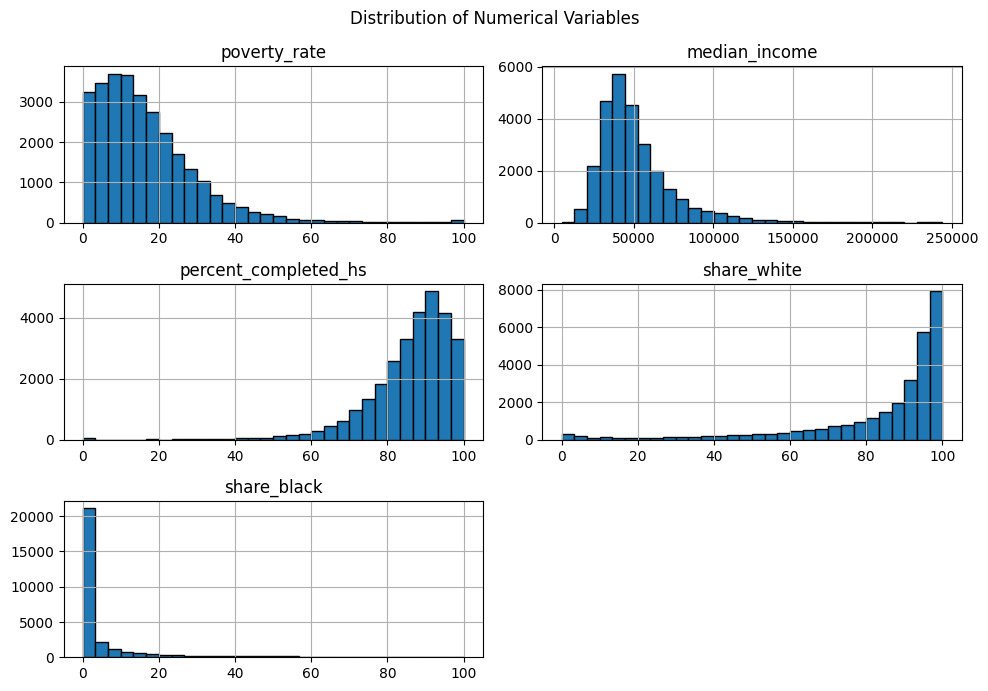

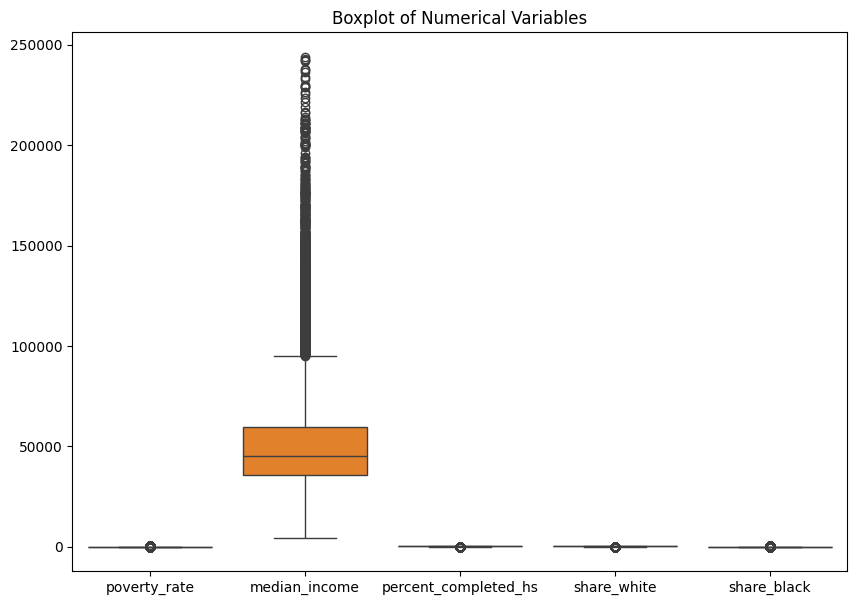

In [15]:
query_2 = """
SELECT * FROM city_demographics_view;
"""

# Получаем данные
df_correlation = conn.execute(query_2).fetchdf()

# Преобразуем столбцы в float, заменяя значения, которые не могут быть преобразованы
columns_to_convert = ['poverty_rate', 'median_income', 'percent_completed_hs', 'share_white', 'share_black']

for col in columns_to_convert:
    df_correlation[col] = pd.to_numeric(df_correlation[col], errors='coerce')  # Заменяет нечисловые значения на NaN

# Визуализируем распределение числовых данных с помощью гистограммы
plt.figure(figsize=(10, 7))

# Гистограмма для всех числовых столбцов
df_correlation[columns_to_convert].hist(bins=30, figsize=(10, 7), edgecolor='black')
plt.suptitle('Distribution of Numerical Variables')
plt.tight_layout()
plt.show()

# Также можно использовать boxplot для поиска выбросов
plt.figure(figsize=(10, 7))
sns.boxplot(data=df_correlation[columns_to_convert])
plt.title('Boxplot of Numerical Variables')
plt.show()

### 3.	Меры центральной тенденции (среднее, медиана, мода). Можно сделать bar chart.

##### Описание:
* Среднее, медиана и мода — ключевые статистики, описывающие “центр” распределения числовых данных.
##### Зачем это нужно:
* Позволяет понять, где сосредоточено большинство значений и есть ли перекос.
##### Визуализация:
* Bar chart со значениями средней, медианы и моды по интересующим признакам.


#### Определяем новую предстовлению для нашего метрики

In [16]:
query = "SELECT * FROM city_demographics_view;"
df = conn.execute(query).fetchdf()

# Очистка данных и преобразования на уровне Pandas
df.replace({'-': None, '(X)': None}, inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')

# Преобразуем числовые столбцы в float
numeric_columns = ['poverty_rate', 'median_income', 'percent_completed_hs']  # Укажи нужные столбцы
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Преобразование строк в числа, пропуская ошибки

/var/folders/c1/14lswbr93s7bjydxm5x8g7mm0000gn/T/ipykernel_16987/2808053081.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [17]:
get_basic_info(df, "Merged Data")

Первый 5 строк:
   poverty_rate  median_income  percent_completed_hs  share_white  \
0          78.8          11207                  21.2         67.2   
1          29.1          25615                  69.1         54.4   
2          25.5          42575                  78.9         52.3   
3          30.7          37083                  81.4         99.1   
4          42.0          21667                  68.6         13.2   

   share_black  share_hispanic  share_asian  
0         30.2             1.6          0.0  
1         41.4             3.1          1.0  
2         44.9             2.3          0.3  
3          0.1             0.4          0.1  
4         86.5             0.3          0.0  
📌 Информация о Merged Data
Форма: (29115, 7)

Пропущенные значения:
poverty_rate             195
median_income           1905
percent_completed_hs     191
share_white               19
share_black               19
share_hispanic            19
share_asian               19
dtype: int64

Основная

In [18]:
# Строим коробчатые диаграммы
def plot_boxplots(df, numeric_columns):
    """
    Строит коробчатые диаграммы для каждого числового столбца.
    """
    plt.figure(figsize=(15, 10))
    
    for i, col in enumerate(numeric_columns, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(x=df[col], color="lightgreen")
        plt.title(f"Коробчатая диаграмма для {col}")
        plt.tight_layout()

    plt.show()

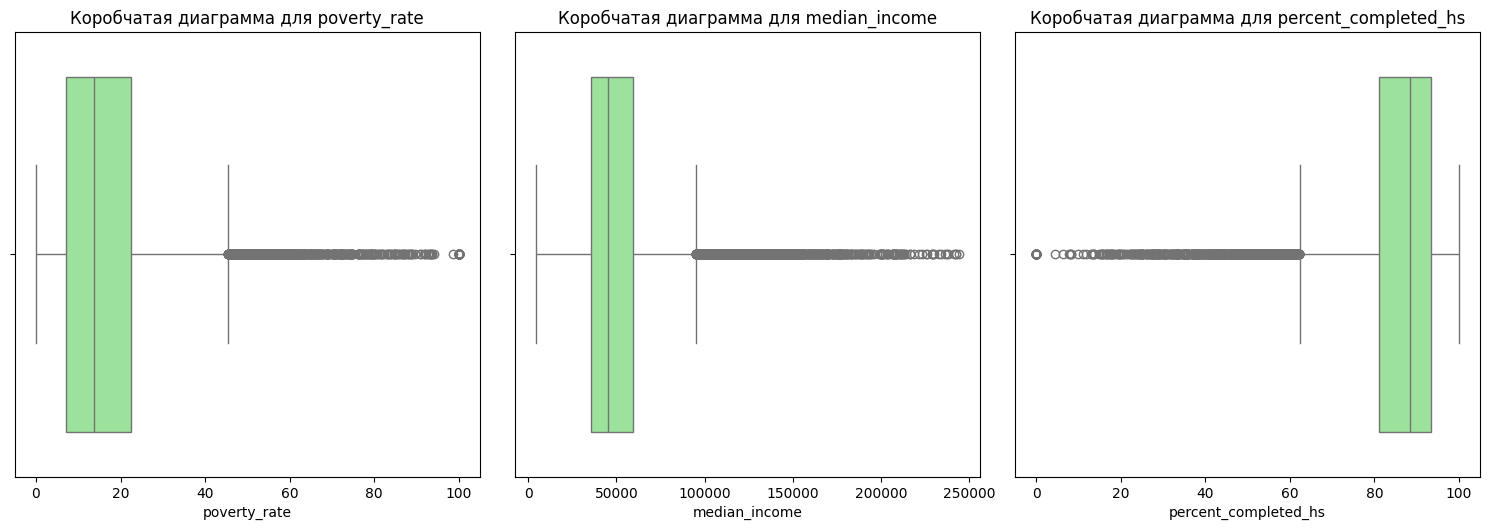

In [19]:
# Визуализируем данные для столбцов
numeric_columns = ['poverty_rate', 'median_income', 'percent_completed_hs']
plot_boxplots(df, numeric_columns)

In [20]:
# Рассчитываем и выводим меры центральной тенденции
def calculate_central_tendency(df: pd.DataFrame, name: str):
    """
    Рассчитывает меры центральной тенденции: среднее, медиану и моду для числовых данных.
    """
    mean_values = df.mean()
    median_values = df.median()
    mode_values = df.mode().iloc[0]  # Берем первый элемент, так как мода может быть несколько

    print(f"📊 Меры центральной тенденции для {name}")
    print(f"Средние значения:\n{mean_values}")
    print(f"Медианы:\n{median_values}")
    print(f"Моды:\n{mode_values}")

    # Строим bar chart для сравнения
    df_stats = pd.DataFrame({
        'Mean': mean_values,
        'Median': median_values,
        'Mode': mode_values
    })

    df_stats = df_stats.reset_index().melt(id_vars=['index'], var_name='Measure', value_name='Value')
    df_stats.columns = ['Variable', 'Measure', 'Value']

    # Строим bar plot для среднего, медианы и моды
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Variable', y='Value', hue='Measure', data=df_stats, palette='Set2', ci=None)
    plt.title(f'Центральные тенденции (Среднее, Медиана и Мода)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

📊 Меры центральной тенденции для city demographics view
Средние значения:
poverty_rate               16.441978
median_income           51159.964792
percent_completed_hs       85.737408
share_white                83.215356
share_black                 6.842429
share_hispanic              9.281083
share_asian                 1.540308
dtype: Float64
Медианы:
poverty_rate               13.7
median_income           45278.0
percent_completed_hs       88.4
share_white                92.5
share_black                 0.8
share_hispanic              2.9
share_asian                 0.4
dtype: Float64
Моды:
poverty_rate                0.0
median_income           38750.0
percent_completed_hs      100.0
share_white               100.0
share_black                 0.0
share_hispanic              0.0
share_asian                 0.0
Name: 0, dtype: Float64


/var/folders/c1/14lswbr93s7bjydxm5x8g7mm0000gn/T/ipykernel_16987/2649507561.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Variable', y='Value', hue='Measure', data=df_stats, palette='Set2', ci=None)


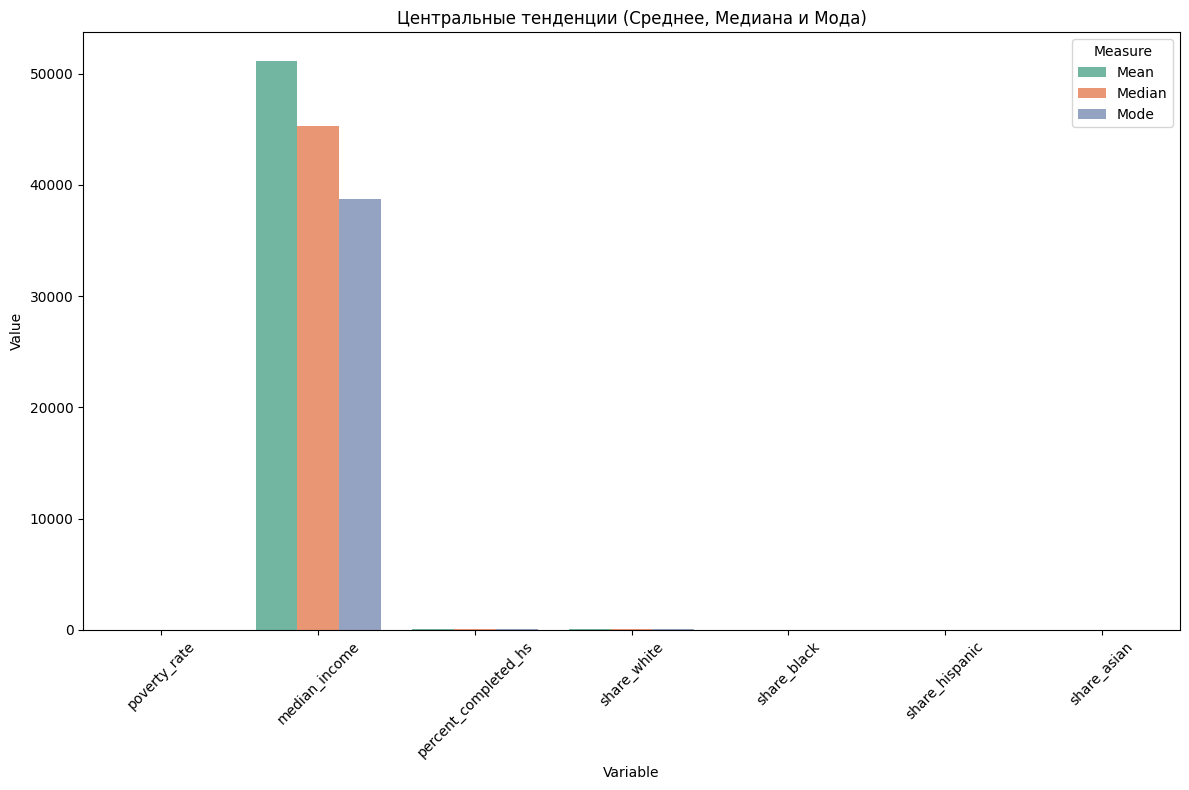

In [21]:
# Вызываем функцию для анализа
calculate_central_tendency(df, "city demographics view")

### 4.	Размах и дисперсия (разница между мин/макс и стандартное отклонение). Хорошо смотрится на boxplot.


##### Используем оба придстовление который создали до этого

Размах:
poverty_rate               100.0
median_income           239572.0
percent_completed_hs       100.0
share_white                100.0
share_black                100.0
share_asian                 67.1
share_hispanic             100.0
dtype: Float64

Стандартное отклонение:
poverty_rate               13.158907
median_income           24862.732172
percent_completed_hs       11.842763
share_white                21.664189
share_black                15.634056
share_asian                 4.283947
share_hispanic             17.474546
dtype: Float64


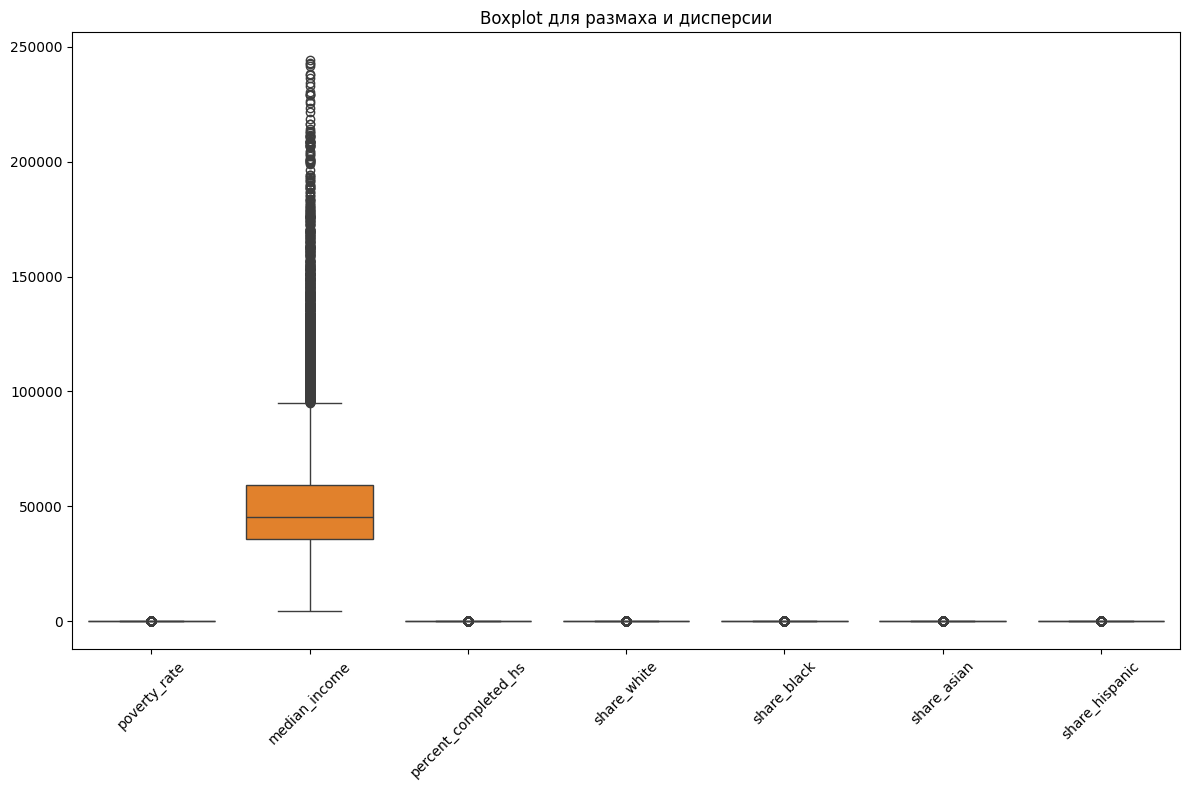

In [22]:
# Загрузка данных
query = "SELECT * FROM city_demographics_view;"
df = conn.execute(query).fetchdf()

# Очистка данных: заменяем текстовые значения на NaN и преобразуем все столбцы в числовые
df.replace({'-': None, '(X)': None}, inplace=True)

# Преобразуем все столбцы в числовые (если возможно), ошибки игнорируются
df = df.apply(pd.to_numeric, errors='coerce')

# Рассчитываем размах и стандартное отклонение
numeric_columns = ['poverty_rate', 'median_income', 'percent_completed_hs', 
                   'share_white', 'share_black', 'share_asian', 'share_hispanic']

# Размах и стандартное отклонение
range_values = df[numeric_columns].max() - df[numeric_columns].min()
std_dev_values = df[numeric_columns].std()

# Выводим результаты
print("Размах:")
print(range_values)
print("\nСтандартное отклонение:")
print(std_dev_values)

# Строим boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numeric_columns])
plt.title("Boxplot для размаха и дисперсии")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5.	Распределение категориальных данных (bar chart с частотами категорий).


##### Описание:
* Частота появления разных значений в категориальном столбце (например, классы, регионы, статусы).

##### Зачем это нужно:
* Помогает выявить дисбаланс между категориями или доминирующие группы.

##### Визуализация:
* Bar chart по значениям категорий.


##### Используем представление категориальных данных

In [23]:
# Преобразуем числовые данные в категориальные (например, для доли этнических групп)
def categorize_column(df, column, bins, labels):
    """
    Преобразует числовой столбец в категориальный на основе заданных бинов.
    
    :param df: pandas DataFrame
    :param column: название столбца для категоризации
    :param bins: список граничных значений для бинов
    :param labels: список меток для категорий
    :return: pandas Series с категориальными значениями
    """
    df[column] = pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)
    return df[column]

# Применяем к столбцам с долями этнических групп
ethnic_bins = [0, 25, 50, 75, 100]  # разбиение на диапазоны (0-25%, 25-50%, 50-75%, 75-100%)
ethnic_labels = ['0-25%', '25-50%', '50-75%', '75-100%']

df['share_white_category'] = categorize_column(df, 'share_white', ethnic_bins, ethnic_labels)
df['share_black_category'] = categorize_column(df, 'share_black', ethnic_bins, ethnic_labels)
df['share_asian_category'] = categorize_column(df, 'share_asian', ethnic_bins, ethnic_labels)
df['share_hispanic_category'] = categorize_column(df, 'share_hispanic', ethnic_bins, ethnic_labels)

/var/folders/c1/14lswbr93s7bjydxm5x8g7mm0000gn/T/ipykernel_16987/4198969705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


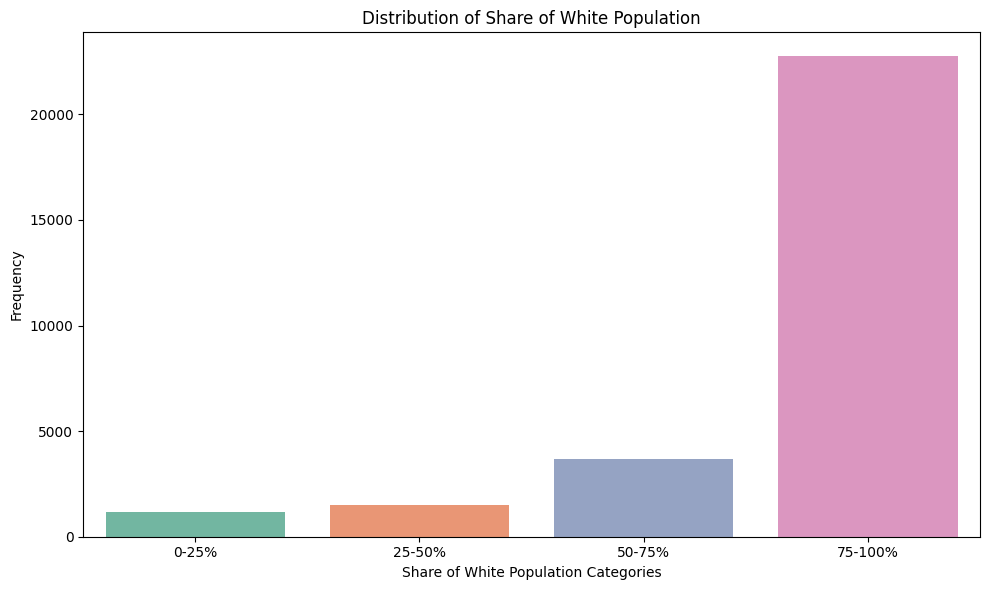

/var/folders/c1/14lswbr93s7bjydxm5x8g7mm0000gn/T/ipykernel_16987/4198969705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


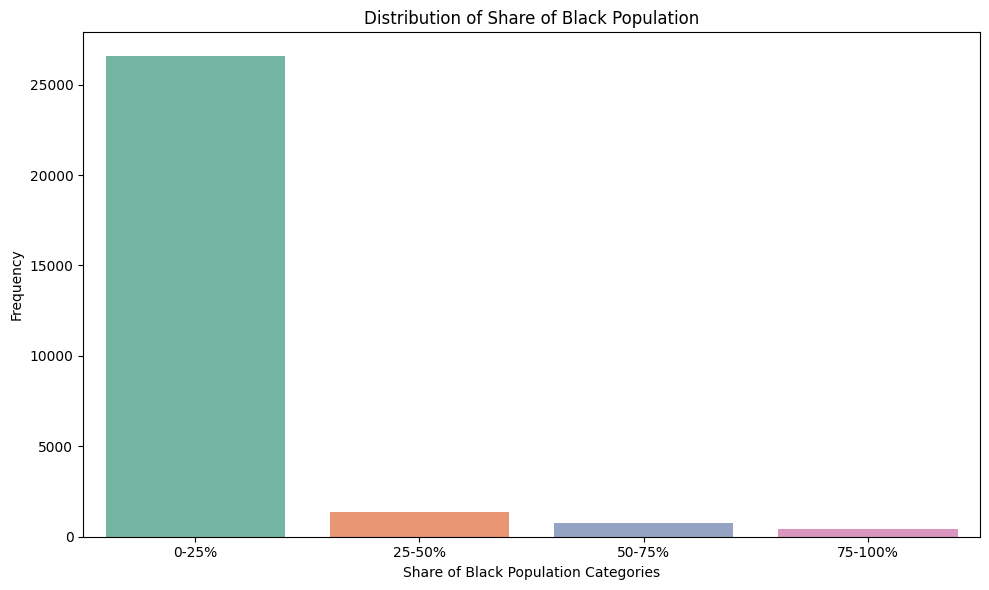

/var/folders/c1/14lswbr93s7bjydxm5x8g7mm0000gn/T/ipykernel_16987/4198969705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


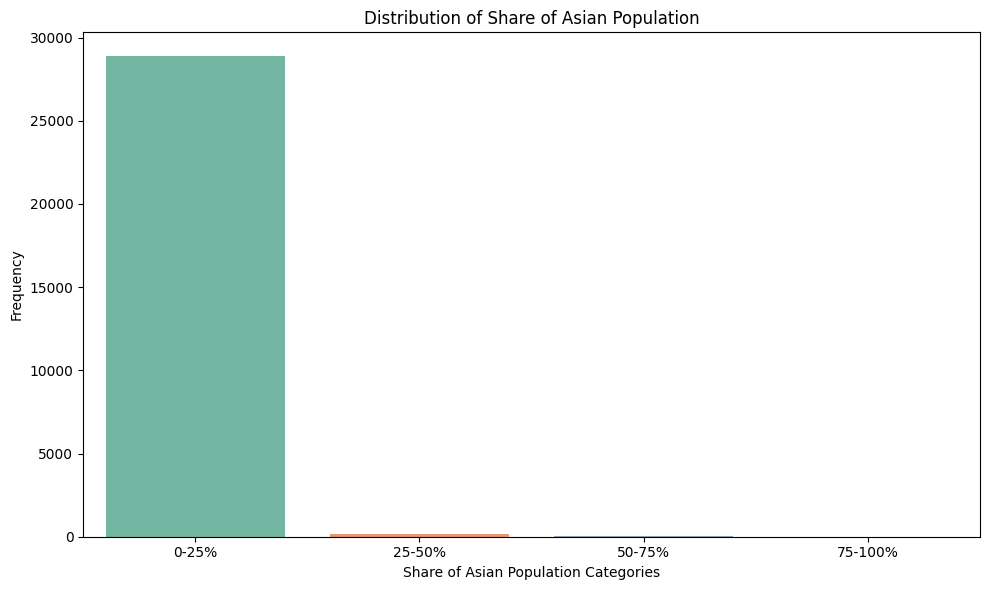

/var/folders/c1/14lswbr93s7bjydxm5x8g7mm0000gn/T/ipykernel_16987/4198969705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


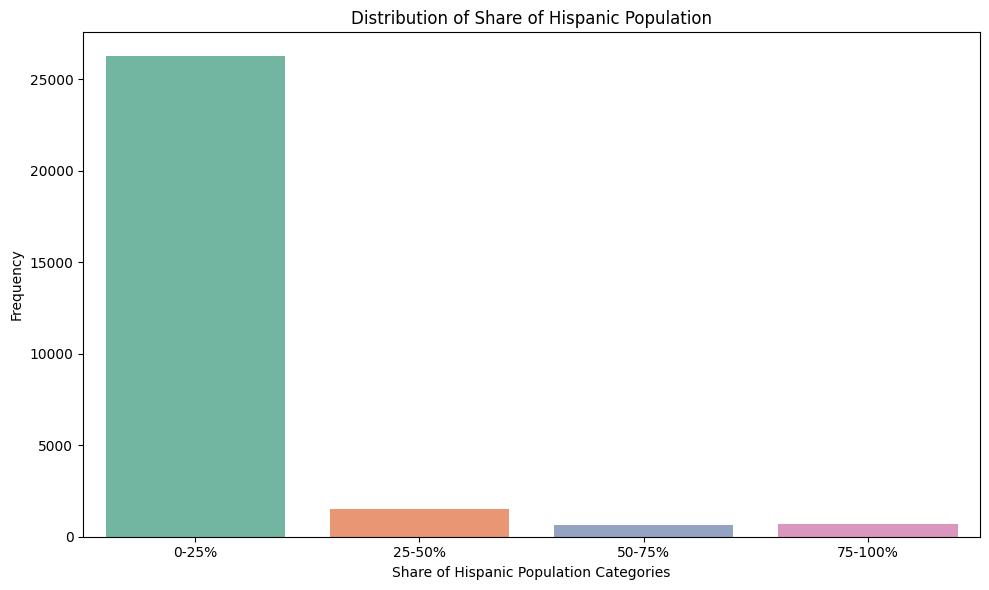

In [24]:
# Для каждого столбца категории создадим bar chart
def plot_category_distribution(df, column, name):
    """
    Строит bar chart для распределения категориальных данных.
    
    :param df: pandas DataFrame
    :param column: название столбца с категориальными данными
    :param name: имя метрики
    :return: None
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column, palette='Set2')
    plt.title(f'Distribution of {name}')
    plt.xlabel(f'{name} Categories')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Строим графики для категориальных данных
plot_category_distribution(df, 'share_white_category', 'Share of White Population')
plot_category_distribution(df, 'share_black_category', 'Share of Black Population')
plot_category_distribution(df, 'share_asian_category', 'Share of Asian Population')
plot_category_distribution(df, 'share_hispanic_category', 'Share of Hispanic Population')

### 6.	Временные ряды (если в данных есть даты, то тренд over time). Строим линейный график.


##### Описание:
* Изучение трендов, изменений и сезонности во времени по одному или нескольким числовым признакам.

##### Зачем это нужно:
* Позволяет отследить развитие показателей, определить тренды, всплески или падения.

##### Визуализация:
* Линейный график (`line plot`) по временной оси.


In [25]:
df.columns = df.columns.str.strip()  # Убирает пробелы в названиях столбцов
print(df.columns)  # Выведет все имена столбцов

Index(['poverty_rate', 'median_income', 'percent_completed_hs', 'share_white',
       'share_black', 'share_hispanic', 'share_asian', 'share_white_category',
       'share_black_category', 'share_asian_category',
       'share_hispanic_category'],
      dtype='object')


In [26]:
# Загрузка данных с временной меткой (если требуется из базы данных)
query = "SELECT * FROM PercentOver25CompletedHighSchool;"
df = conn.execute(query).fetchdf()

# Преобразование даты в формат datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=False)

# Извлекаем год из столбца даты
df['year'] = df['date'].dt.year

/var/folders/c1/14lswbr93s7bjydxm5x8g7mm0000gn/T/ipykernel_16987/1966829548.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=False)


In [27]:
# Преобразуем столбец 'date' в тип данных datetime, если это необходимо
df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=False)

# Извлекаем год из столбца даты
df['year'] = df['date'].dt.year

# Преобразуем колонку 'age' в числовой формат, ошибки будут заменяться на NaN
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Агрегируем данные по годам (вычисляем среднее и стандартное отклонение)
age_by_year = df.groupby('year')['age'].agg(['mean', 'std']).reset_index()

# Преобразуем 'mean' и 'std' в числовой формат, если они еще не были преобразованы
age_by_year['mean'] = pd.to_numeric(age_by_year['mean'], errors='coerce')
age_by_year['std'] = pd.to_numeric(age_by_year['std'], errors='coerce')

# Проверим типы данных в агрегированном DataFrame и наличие NaN
print(age_by_year.dtypes)
print(age_by_year.isna().sum())

year      int32
mean    float64
std     float64
dtype: object
year    0
mean    0
std     0
dtype: int64


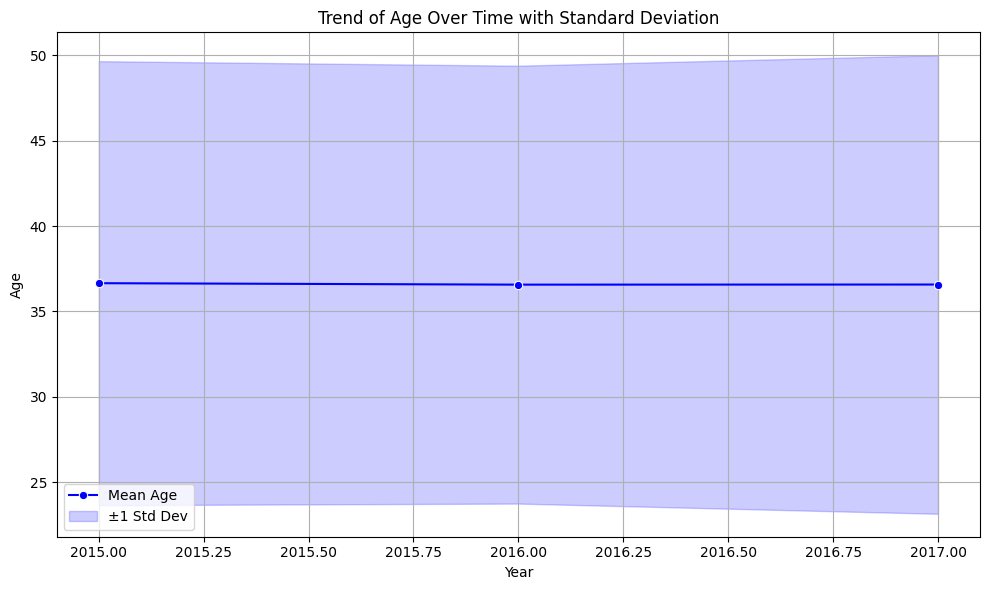

In [28]:
def plot_time_series(df, column, name):
    """
    Строит линейный график для тренда по времени с отображением стандартного отклонения (заливка).
    
    :param df: pandas DataFrame
    :param column: название столбца для анализа (например, 'age')
    :param name: имя метрики
    :return: None
    """
    plt.figure(figsize=(10, 6))
    
    # Линия среднего значения
    sns.lineplot(x='year', y='mean', data=df, marker='o', color='b', label=f'Mean {name}')
    
    # Добавим заливку между (mean - std) и (mean + std)
    plt.fill_between(df['year'],
                     df['mean'] - df['std'],
                     df['mean'] + df['std'],
                     color='blue',
                     alpha=0.2,
                     label='±1 Std Dev')
    
    plt.title(f'Trend of {name} Over Time with Standard Deviation')
    plt.xlabel('Year')
    plt.ylabel(name)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()
# Вызов функции для построения графика по возрасту
plot_time_series(age_by_year, 'age', 'Age')

### 7.	Сравнение уровня дохода и образования по разным долям рас (кластеризация/сегментация по race-share)

##### Описание:
* Разделение выборки на группы (`Low`, `Medium`, `High`) по доле чернокожего населения и сравнение средних значений по доходу, уровню образования и бедности.

##### Зачем это нужно:
* Позволяет выявить различия в социально-экономических показателях в зависимости от расового состава.

##### Визуализация:
* Bar chart по группам (`black_group`) с метриками: `median_income`, `percent_completed_hs`, `poverty_rate`.

In [29]:
query = "SELECT * FROM city_demographics_view"
df = conn.execute(query).fetchdf()

# Преобразуем нужные столбцы в числовой формат
cols_to_numeric = [
    'poverty_rate',
    'median_income',
    'percent_completed_hs',
    'share_white',
    'share_asian',
    'share_hispanic',
    'share_black'
]

for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Проверка: типы после преобразования
print(df.dtypes)

# Создаём группы по доле чернокожих
df['black_group'] = pd.qcut(df['share_black'], q=3, labels=['Low', 'Medium', 'High'])

# Группируем и считаем средние значения
group_stats = df.groupby('black_group')[['median_income', 'percent_completed_hs', 'poverty_rate']].mean().reset_index()

print(group_stats)

poverty_rate            float64
median_income             Int32
percent_completed_hs    float64
share_white             float64
share_black             float64
share_hispanic          float64
share_asian             float64
dtype: object
  black_group  median_income  percent_completed_hs  poverty_rate
0         Low    46873.33107             85.780916     16.408481
1      Medium   55938.489158             87.511253     14.340092
2        High   50563.572443             83.959431     18.531283


/var/folders/c1/14lswbr93s7bjydxm5x8g7mm0000gn/T/ipykernel_16987/846689734.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('black_group')[['median_income', 'percent_completed_hs', 'poverty_rate']].mean().reset_index()


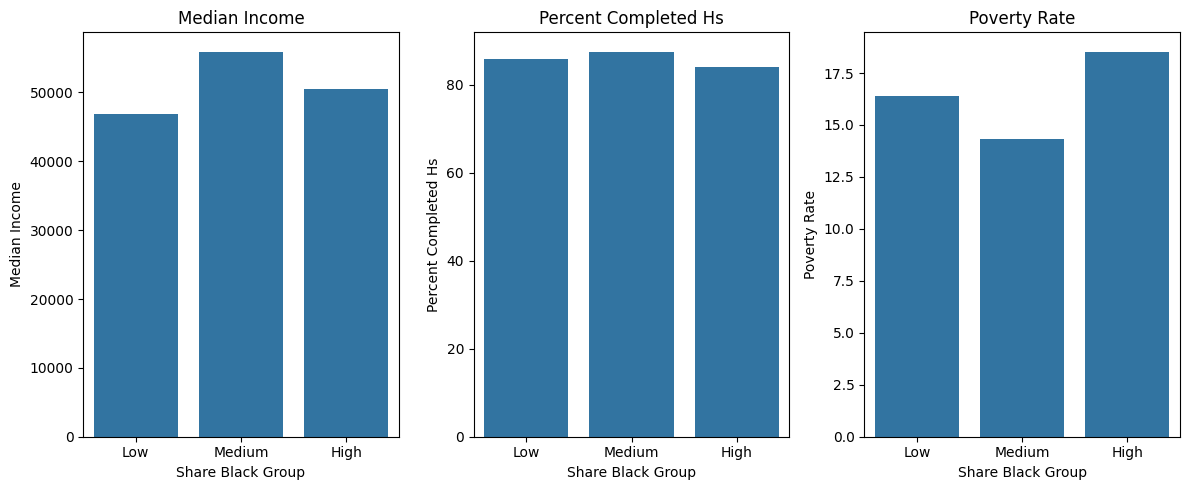

In [30]:
plt.figure(figsize=(12, 5))

for i, col in enumerate(['median_income', 'percent_completed_hs', 'poverty_rate']):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='black_group', y=col, data=group_stats)
    plt.title(col.replace('_', ' ').title())
    plt.xlabel('Share Black Group')
    plt.ylabel(col.replace('_', ' ').title())

plt.tight_layout()
plt.show()

In [31]:
conn.close()